<a href="https://colab.research.google.com/github/avionerman/computational_and_statistical/blob/main/CI%26SL3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [3]:

# Core scientific computing
import numpy as np
from numpy.linalg import eigh, eig, svd, norm, inv
from scipy.sparse import csr_matrix, diags, eye as sparse_eye
from scipy.sparse.linalg import eigsh, eigs
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.sparse.csgraph import shortest_path

# Machine Learning
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    confusion_matrix,
    accuracy_score
)
from sklearn.decomposition import PCA

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# utilities
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple
from enum import Enum, auto
import warnings
import time

warnings.filterwarnings('ignore')

# set random seeds for reproducibility for the rest of the code
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configuration attributes

In [9]:
@dataclass
class Config:

    # data
    sample_fraction: float = 0.25      # using x% of the data for faster experimenting
    normalize_method: str = 'minmax'   # avail options: 'minmax', 'standard'
    random_seed: int = 42

    # graph
    n_neighbors: int = 15 # k for kNN graph
    sigma: float = None   # gaussian kernel bandwidth (none = auto-estimate)

    # enable/disable methods
    enable_laplacian_eigenmaps: bool = True
    enable_lpp: bool = True
    enable_isomap: bool = True
    enable_lle: bool = True
    enable_tsne: bool = True

    # spectral settings
    n_clusters_list: List[int] = field(default_factory=lambda: [2, 3, 5, 7, 10])

    # tSNE only
    tsne_perplexity: float = 30.0
    tsne_n_iter: int = 1000


config = Config()

print(">>> Configuration set")
print(f"   Sample fraction: {config.sample_fraction * 100:.0f}%")
print(f"   n_neighbors: {config.n_neighbors}")
print(f"   Methods enabled: LE={config.enable_laplacian_eigenmaps}, LPP={config.enable_lpp}, "
      f"Isomap={config.enable_isomap}, LLE={config.enable_lle}, t-SNE={config.enable_tsne}")

>>> Configuration set
   Sample fraction: 25%
   n_neighbors: 15
   Methods enabled: LE=True, LPP=True, Isomap=True, LLE=True, t-SNE=True


# Data preprocessing

In [15]:
def load_mnist():
    from tensorflow.keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    class_names = [str(i) for i in range(10)]
    return x_train, y_train, x_test, y_test, class_names

def load_cifar10():
    from tensorflow.keras.datasets import cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train, y_test = y_train.flatten(), y_test.flatten()
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    return x_train, y_train, x_test, y_test, class_names

def sample_data(x, y, fraction, random_seed=RANDOM_SEED):
    from sklearn.model_selection import train_test_split

    x_sample, _, y_sample, _ = train_test_split(
        x, y,
        train_size=fraction,
        stratify=y, # enable stratification for fair representation
        random_state=random_seed
    )
    return x_sample, y_sample

def preprocess_data(x, y, config):
    # sample, flatten, normalize to [0,1].

    x, y = sample_data(x, y, config.sample_fraction, config.random_seed)

    # flatten and normalize (images are 0-255 move under scale to 0-1)
    x_flat = x.reshape(len(x), -1).astype(np.float32) / 255.0

    return x_flat, y

# Data loading

In [17]:
# loading MNIST
print(">>> Loading MNIST")
x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist, mnist_classes = load_mnist()
x_mnist, y_mnist = preprocess_data(x_train_mnist, y_train_mnist, config)
print(f"MNIST: {x_mnist.shape[0]} samples, {x_mnist.shape[1]} features")

# loading CIFAR10
print(">>> Loading CIFAR10")
x_train_cifar, y_train_cifar, x_test_cifar, y_test_cifar, cifar_classes = load_cifar10()
x_cifar, y_cifar = preprocess_data(x_train_cifar, y_train_cifar, config)
print(f"CIFAR10: {x_cifar.shape[0]} samples, {x_cifar.shape[1]} features")

print(">>> Data loaded and preprocessed")

>>> Loading MNIST
MNIST: 15000 samples, 784 features
>>> Loading CIFAR10
CIFAR10: 12500 samples, 3072 features
>>> Data loaded and preprocessed


# Datasets visualization

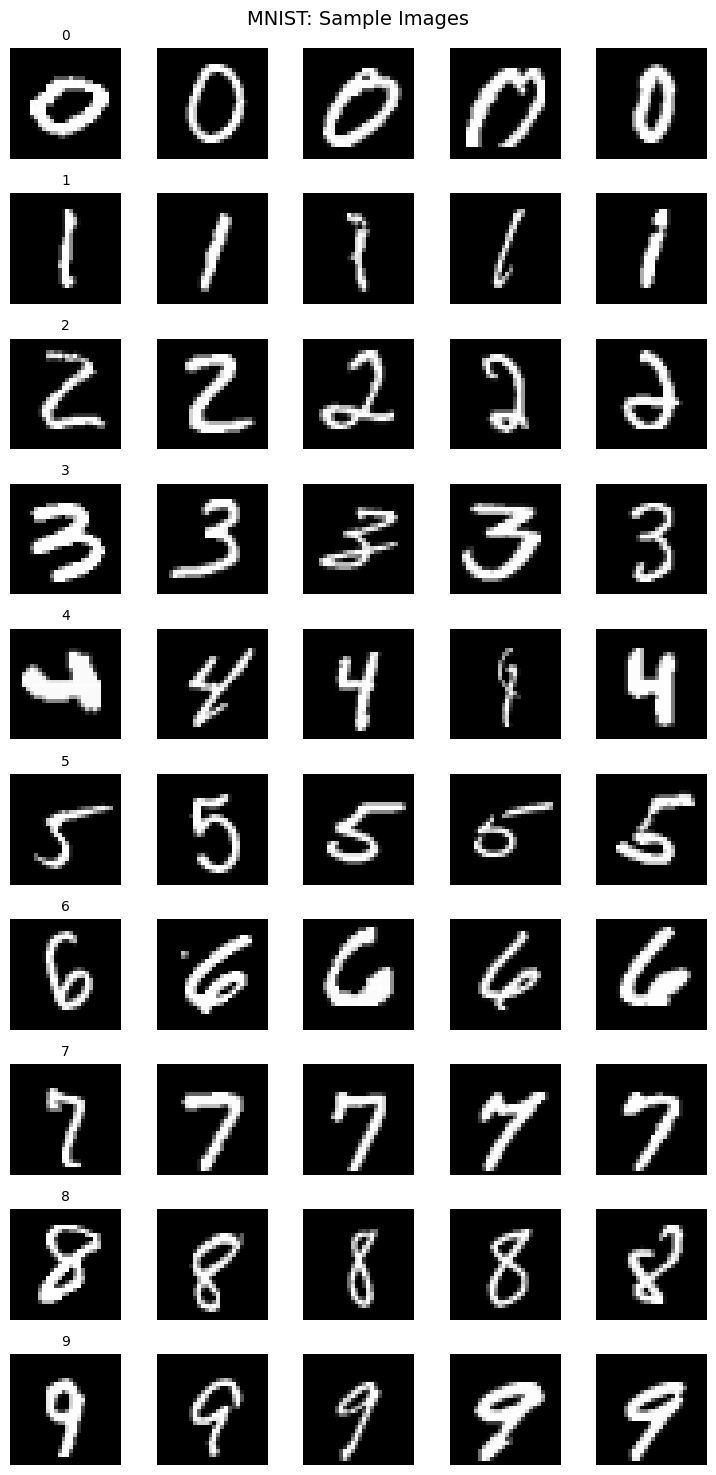

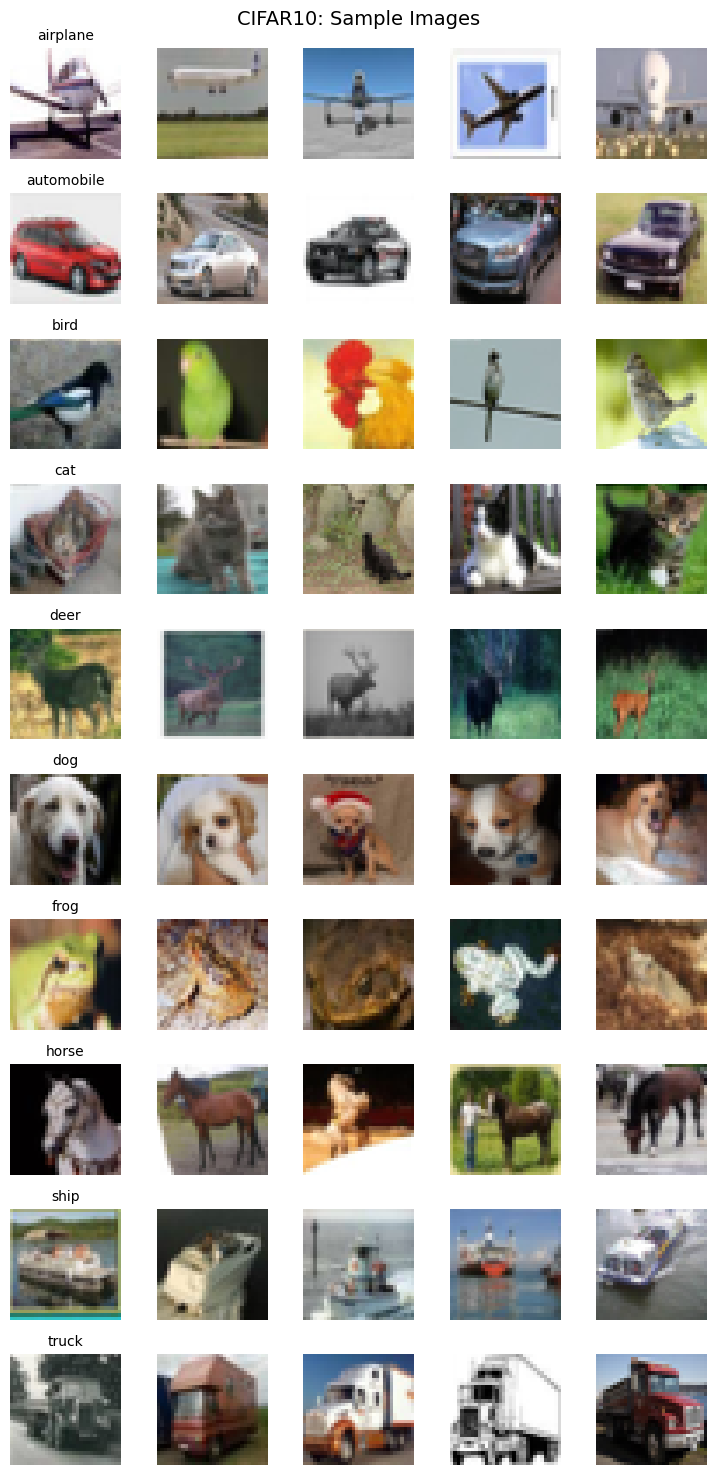

In [19]:
def visualize_samples(x_original, y, class_names, dataset_name, n_samples=5):
    # present sample images from each class
    n_classes = len(class_names)
    fig, axes = plt.subplots(n_classes, n_samples, figsize=(n_samples * 1.5, n_classes * 1.5))
    fig.suptitle(f'{dataset_name}: Sample Images', fontsize=14)

    for row, cls in enumerate(range(n_classes)):
        # get images of this class
        cls_indices = np.where(y == cls)[0]
        selected = np.random.choice(cls_indices, size=n_samples, replace=False)

        for col, idx in enumerate(selected):
            ax = axes[row, col]
            img = x_original[idx]

            # handling grayscale (MNIST) vs rbg (CIFAR10)
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)

            ax.axis('off')
            if col == 0:
                ax.set_title(class_names[cls], fontsize=10)

    plt.tight_layout()
    plt.show()



visualize_samples(x_train_mnist, y_train_mnist, mnist_classes, 'MNIST')
print("\n\n")
visualize_samples(x_train_cifar, y_train_cifar, cifar_classes, 'CIFAR10')